Let’s perform a sample implementation of the ARIMA and SARIMA models on CPU utilization data to predict its thresholds.

Begin by importing the required Python libraries.

In [ ]:
# Library for Data Manipulation
import pandas as pd
import numpy as np
# Library for Data Visualization
import matplotlib.pyplot as plt
# Library for Time Series Models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
# Library for Machine Learning
from sklearn.metrics import mean_squared_log_error
# Library for Track time
from datetime import datetime 

Read data on CPU utilization from a CSV in a Pandas data frame and check information about the data types, column names, and count of values present in imported data.

In [ ]:
cpu_util_raw_data= pd.read_csv("cpu_utilization-data.csv")
cpu_util_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_time        404 non-null    object 
 1   cpu_utilization  404 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.4+ KB


Set the data type of column date_time to DateTime, set it as an index to sort the data points in a data frame, and plot the CPU utilization on a time scale, as shown in Figure 7-18.

<Axes: xlabel='date_time'>

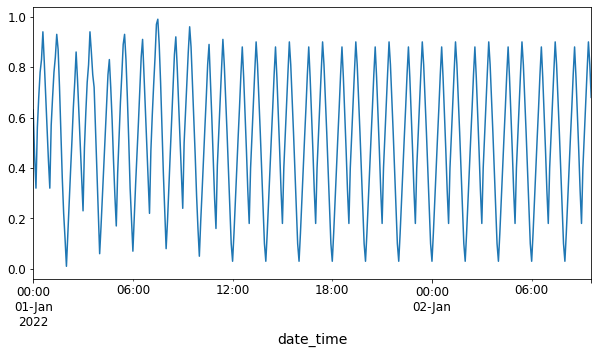

In [ ]:
total_records = cpu_util_raw_data.count()['cpu_utilization']
cpu_util_raw_data['date_time'] = pd.to_datetime(cpu_util_raw_data['date_time'])
cpu_util_raw_data.set_index('date_time',inplace=True)
cpu_util_raw_data = cpu_util_raw_data.sort_values(by="date_time")
fig = plt.figure(figsize =(10, 5))
cpu_util_raw_data['cpu_utilization'].plot()


It is important to check for the outliers in the data using a box plot. The presence of outliers impacts the quality of predictions. If there are a high number of outliers in data, then they need to be either processed or removed from the dataset based on the domain requirements.


Outlier Percentage in data: {}  0.76
Outlier Percentage in data: 0.0%
Zero Value percentage in data:  0.0


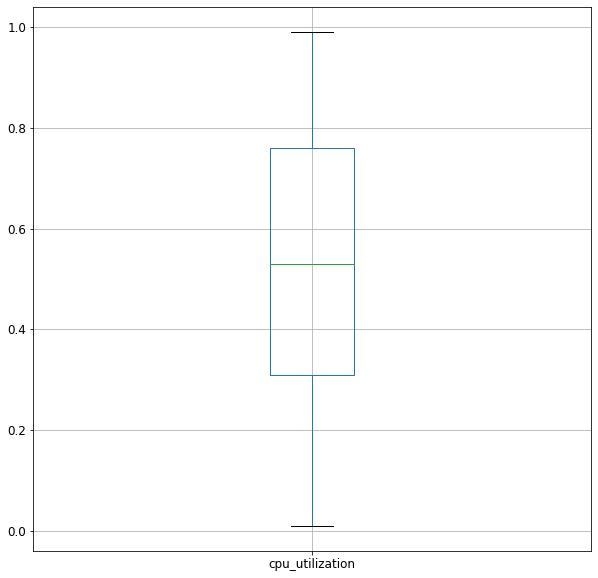

In [ ]:
#Global variables
NOISE = False
MAPE = True
TEST_DATA_SIZE = 0.2 #in percent
SEASONAL = False
def getOutliers(data, col):
    print("Outlier Percentage in data: {} " ,data[col].quantile(0.75))  ;
    Q3 = data[col].quantile(0.75)
    Q1 = data[col].quantile(0.25)

    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit

lower, upper = getOutliers(cpu_util_raw_data, 'cpu_utilization')
outliers_count = cpu_util_raw_data[(cpu_util_raw_data['cpu_utilization']<lower) | (cpu_util_raw_data['cpu_utilization']>upper)].count()['cpu_utilization']
outlier_percentage = ((outliers_count / total_records) * 100)
if outlier_percentage > 20:
   NOISE = True
print(f"Outlier Percentage in data: {outlier_percentage}%")

#Render box plot
cpu_util_raw_data.boxplot('cpu_utilization', figsize=(10,10))
zero_values = cpu_util_raw_data[(cpu_util_raw_data['cpu_utilization']==0)].count()['cpu_utilization']
zero_values_percentage = ((zero_values / total_records) * 100)
if zero_values_percentage > 20:
    MAPE = False
print("Zero Value percentage in data: ", zero_values_percentage)

Let’s check for the stationarity of a time series using an ADF test. Based on an ADF test, if the p-value comes out to more than 0.05, it means the time series is nonstationary and needs to be differenced using the diff() function and again checked with an ADF test for stationarity.

In [ ]:
diff_count = 0
differencing_order = {
    1: lambda x: x['cpu_utilization'].diff(),
    2: lambda x: x['cpu_utilization'].diff().diff(),
    3: lambda x: x['cpu_utilization'].diff().diff().diff(),
    4: lambda x: x['cpu_utilization'].diff().diff().diff().diff(),
    5: lambda x: x['cpu_utilization'].diff().diff().diff().diff().diff()
}
while True:
    if diff_count == 0:
        adftestresult = adfuller(cpu_util_raw_data['cpu_utilization'].dropna())
    else:
        adftestresult = adfuller(differencing_order[diff_count](cpu_util_raw_data).dropna())
    print('#' * 60)
    print('ADF Statistic: %f' % adftestresult[0])
    print('p-value: %f' % adftestresult[1])
    print(f'ADF Test Result: The time series is {"non-" if adftestresult[1] >= 0.05 else ""}stationary')
    print('#' * 60)
    if adftestresult[1] < 0.05 or diff_count >= len(differencing_order):
        break
    diff_count += 1
print("Differencing order to make data stationary: ",diff_count)

############################################################
ADF Statistic: -8.346295
p-value: 0.000000
ADF Test Result: The time series is stationary
############################################################
Differencing order to make data stationary:  0


The ADF result on differenced time series shows that the p-value is 0, which confirms that data series is now stationary. This can be visualized by plotting both the original series and a differenced series on a time scale graph, as shown in Figure 7-20.

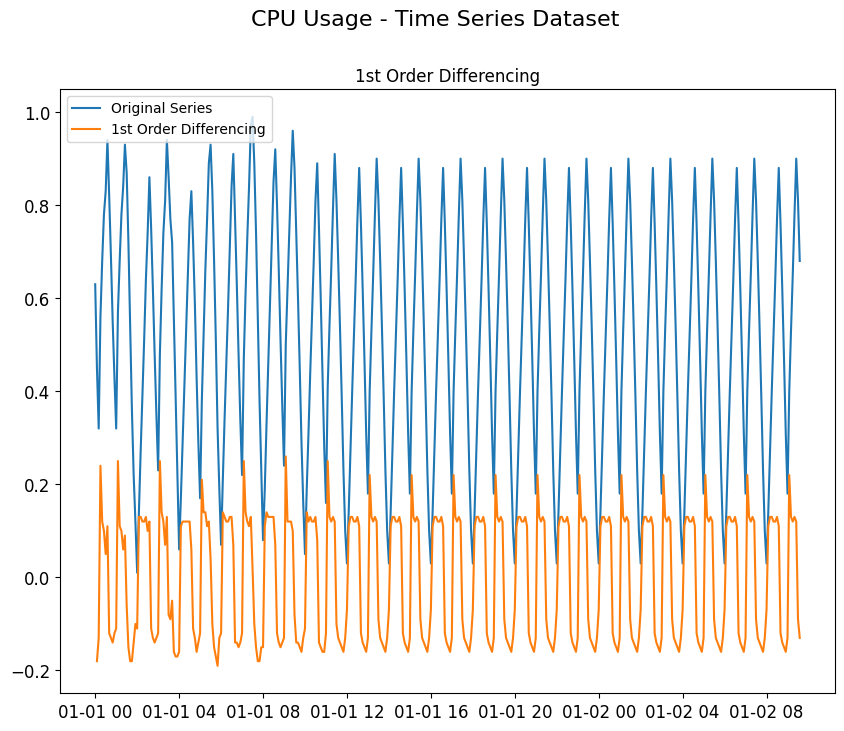

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), dpi=100)
#  Differencing
ax.plot(cpu_util_raw_data.cpu_utilization[:], label='Original Series')
ax.plot(cpu_util_raw_data.cpu_utilization.diff(1), label='1st Order Differencing')
ax.set_title('1st Order Differencing')
ax.legend(loc='upper left', fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('CPU Usage - Time Series Dataset', fontsize=16)
plt.show()

As we have done differencing only one time, we can set the value of the differencing (d) component of ARIMA as d=1.

Next let’s plot the ACF and PACF graph to get the value of the AR (p) and MA (q) components.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


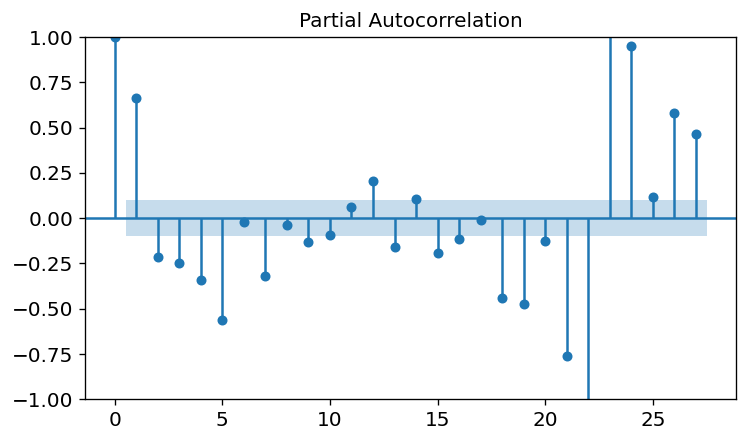

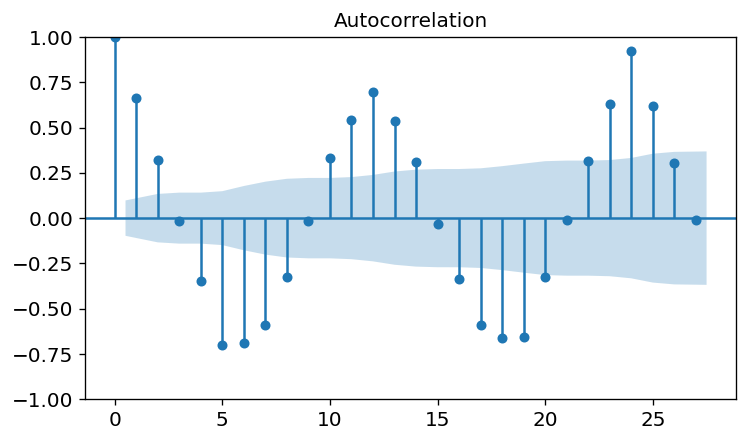

In [ ]:
plt.rcParams.update({'figure.figsize':(7, 4), 'figure.dpi':120})
plot_pacf(cpu_util_raw_data.cpu_utilization.diff().dropna());
plot_acf(cpu_util_raw_data.cpu_utilization.diff().dropna());

In the PACF graph in Figure 7-21, it can be observed that until lag 6 it is crossing the significant line, so the AR component, p=6, can be initially set for modeling.
In the ACF graph in Figure 7-22, there is sharp cut-off on the lag 2 and lag 7 crossing significance line, so we can try with the MA component as q=2 or q =7 for modeling.

Next split the data into training and test data to be used for the ARIMA model (6,1,2). Out of 396 data points, let’s use the first 300 (~75 percent) data points for training and the rest of the data points for testing purposes and plot them on a time scale, as shown in Figure 7-23.

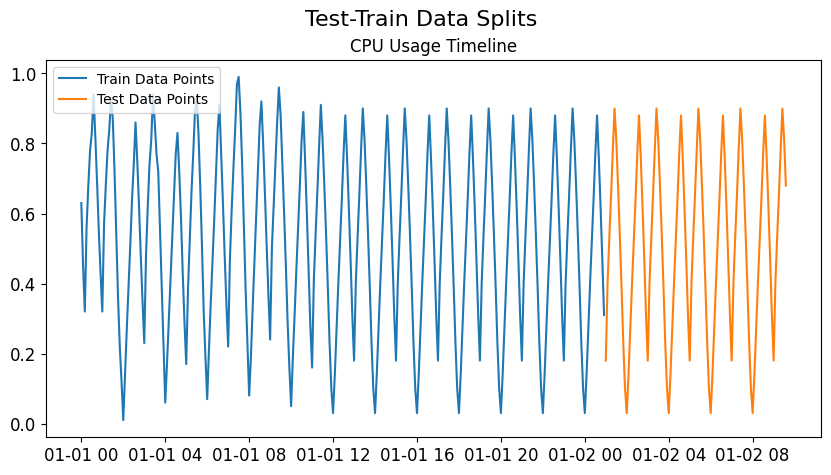

In [ ]:
# Plot train and test data
train_data = cpu_util_raw_data['cpu_utilization'][:300]
test_data = cpu_util_raw_data['cpu_utilization'][300:]
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(train_data, label='Train Data Points')
ax.plot(test_data, label='Test Data Points')
ax.set_title('CPU Usage Timeline')
ax.legend(loc='upper left', fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Test-Train Data Splits', fontsize=16)
plt.show()

Let’s create the ARIMA (6,1,2) model using the train data.

In [ ]:
manual_arima_model = ARIMA(train_data, order=(6,1,2))
manual_arima_model_fit = manual_arima_model.fit()
print(manual_arima_model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        cpu_utilization   No. Observations:                  300
Model:                 ARIMA(6, 1, 2)   Log Likelihood                 380.116
Date:                Sat, 25 Mar 2023   AIC                           -742.232
Time:                        10:46:34   BIC                           -708.928
Sample:                    01-01-2022   HQIC                          -728.902
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5358      0.088      6.110      0.000       0.364       0.708
ar.L2          0.4999      0.101      4.950      0.000       0.302       0.698
ar.L3         -0.3773      0.099     -3.828      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Before applying this model on the test data, the ARIMA model needs to be checked for accuracy with the chosen combination of component values, p,d,q. There are two key statistical measures to compare the relative quality of the different models.

* Akaike information criteria (AIC): This validates the model in terms of goodness of fit of the data by checking how much it relies on the tuning parameters. The lower the value of AIC, the better the model performance. The current ARIMA (6,1,2) model has an AIC value of 2113.

* Bayesian information criteria (BIC): In addition to AIC, the BIC uses the number of samples in the training dataset that are used for fitting. Here also a model with a lower BIC is preferred. The current ARIMA (6,1,2) model has a BIC value of 2150.

Based on PACF and ACF charts, multiple values can be tried to lower the AIC and BIC values. For now let’s proceed with ARIMA (6,1,2).

Let’s plot the actual values in a training dataset with the model’s predicted value to analyze how close the actual and model predicted values are.

<Figure size 1500x500 with 0 Axes>

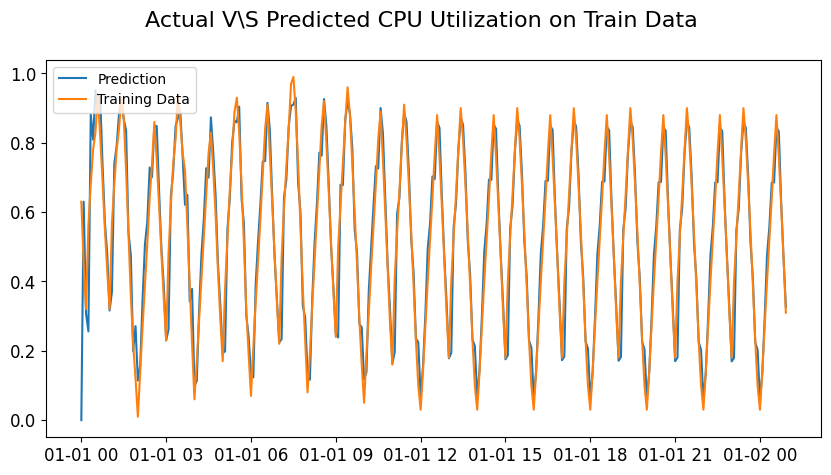

In [ ]:
prediction_manual=manual_arima_model_fit.predict(dynamic=False,typ='levels')
plt.figure(figsize=(15,5), dpi=100)
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(prediction_manual, label='Prediction')
ax.plot(train_data, label='Training Data')
ax.legend(loc='upper left', fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Actual V\S Predicted CPU Utilization on Train Data', fontsize=16)
plt.show()

As observed in Figure 7-25, the model predictions are quite close to actual values, indicating that it gets trained quite well.

Now let’s validate the model performance on the test data.

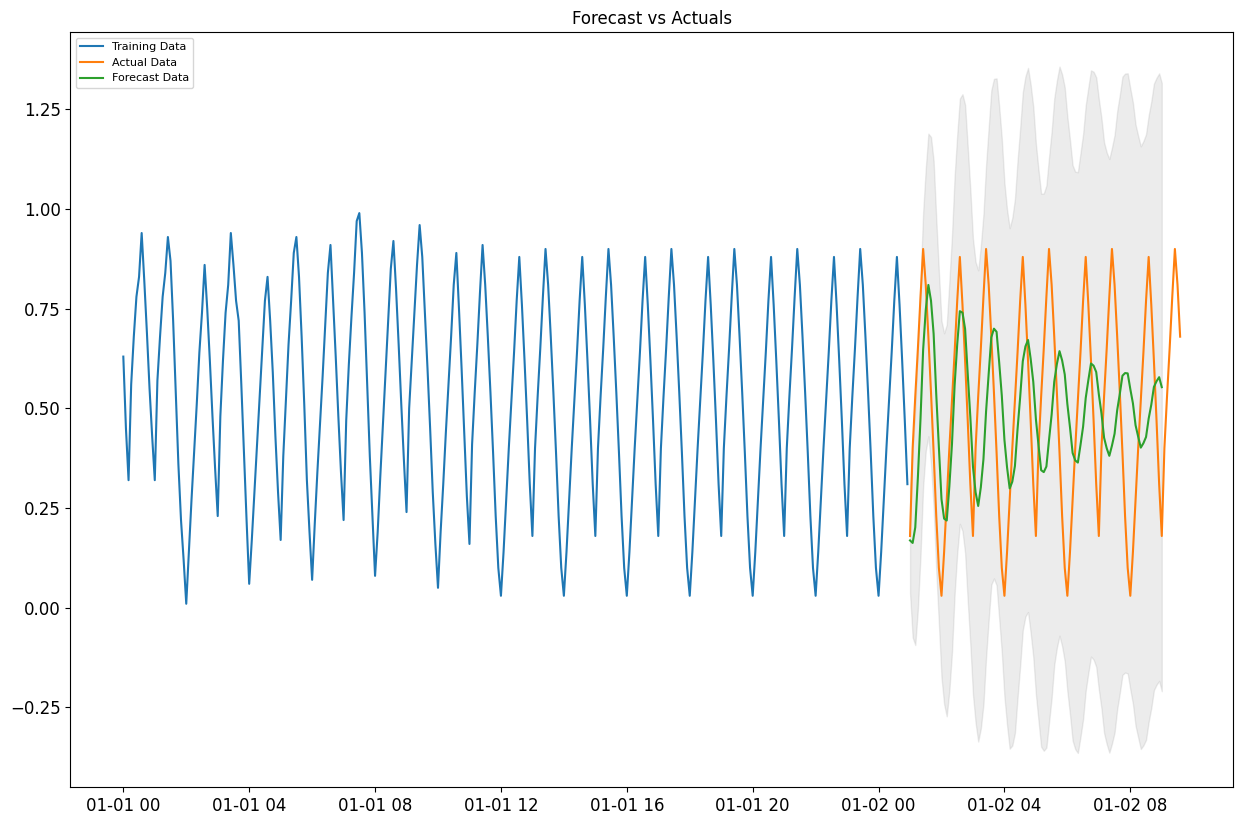

In [ ]:
# Forecast with 95% confidence interval
forecast = manual_arima_model_fit.get_forecast(97)
manual_arima_fc = forecast.predicted_mean
manual_arima_conf = forecast.conf_int(alpha=0.05)
manual_arima_fc_series = pd.Series(manual_arima_fc, index=test_data.index)
manual_arima_lower_series = pd.Series(manual_arima_conf["lower cpu_utilization"],
 index=manual_arima_conf.index)
manual_arima_upper_series = pd.Series(manual_arima_conf["upper cpu_utilization"],
 index=manual_arima_conf.index)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data')
plt.plot(manual_arima_fc_series, label='Forecast Data')
plt.fill_between(manual_arima_lower_series.index, manual_arima_lower_series,
 manual_arima_upper_series, color='gray', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Figure 7-26 shows that the ARIMA (6,1,2) model performance on the test dataset is not good and its predictions are deteriorating over time.

Let’s quantify the model performance with the metrics defined earlier.

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)*100)
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5
    rmsle = np.sqrt(mean_squared_log_error(actual, forecast))
    return({'MAPE : ':mape, 'MAE : ': mae, 'RMSE : ':rmse, 'RMSLE : ':rmsle })
forecast_accuracy(manual_arima_fc, test_data)

ValueError: ignored

Based on the performance metrics, the model predictions are about 76 percent (MAPE = ~24 percent) accurate.

In practical scenarios, multiple values of ARIMA components need to be used to arrive at a model with maximum accuracy in predictions. Manually performing this task requires a lot of time and expertise in statistical techniques. Also, it becomes practically impossible to create models for a large number of entities such as servers, parameters, stocks, etc.

There are ML approaches called Auto ARIMA to learn optimal values of the components p,d,q. In Python there is a library called pdarima that provides the function auto_arima to try various values of ARIMA/SARIMA components in model creation and search for most optimal model with the lowest AIC and BIC values.

Let’s try auto ARIMA to find the most optimal component values for the ARIMA model from the given training dataset. In the auto ARIMA model, we currently specify seasonal to be False to explore more about ARIMA. This value will be true for the SARIMA model to consider seasonality. We will also provide the maximum values of p and q that auto ARIMA can explore to obtain the best model. Let’s proceed with max_p and max_q as 15 to limit the complexity of the model.


In [ ]:
# Fit auto_arima on train set
auto_arima_model = pm.auto_arima(train_data, start_p = 1, start_q = 1,
 max_p = 15, max_q = 15,
 seasonal = False,
 d = None, trace = True,
 error_action ='ignore',
 suppress_warnings = True,
 stepwise = True)
# To print the summary
auto_arima_model.summary()

NameError: ignored

As per the auto ARIMA result shown in Figure 7-27, the best model is identified as ARIMA (6,1,0) with marginal improvement in the AIC and BIC values as compared to the previous ARIMA (6,1,2) model.

Next validate the performance of ARIMA (1,1,1) only on test data.

In [ ]:
auto_arima_predictions = pd.Series(auto_arima_model.predict(len(test_data)))
actuals = test_data.reset_index(drop = True)
auto_arima_predictions.plot(legend = True,label = "ARIMA Predictions",
 xlabel = "Index",ylabel = "CPU Utilization",
 figsize=(10, 7))
 actuals.plot(legend = True, label = "Actual");
forecast_accuracy(np.array(auto_arima_predictions), test_data)

IndentationError: ignored

As observed in Figure 7-28 and as the performance metrics are obtained, there is even further degradation in the accuracy of the ARIMA (1,1,1) model.

Clearly, the ARIMA model is not going to work in this scenario, and we need to look for the seasonality in data using the seasonal_decompose package.

In [ ]:
seasonality_check = seasonal_decompose(cpu_util_raw_data['cpu_utilization'],
 model='additive',extrapolate_trend='freq')
seasonality_check.plot()
plt.show()

ValueError: ignored

Based on the graph in Figure 7-29, we can observe seasonality in the data, which implies we should use the SARIMA model.


Let’s explore the SARIMA model using auto ARIMA with seasonality enabled. As we have daily data points and based on the seasonality graph, it seems there is weekly seasonality, so we will be setting the value of the SARIMA component as m = 7.

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
sarima_model = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=15, max_q=15, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
sarima_model.summary()
As shown in Figure 7-30, auto A

SyntaxError: ignored

As shown in Figure 7-30, auto ARIMA tried various combination and has detected SARIMA (3,0,2)(0,1,1)[7] as a best-fit model with considerable improvement in the AIC values as compared to previous ARIMA models.

Let’s validate the results of this new SARIMA model.

In [ ]:
sarima_predictions = pd.Series(sarima_model.predict(len(test_data)))
actuals = test_data.reset_index(drop = True)
sarima_predictions.plot(legend = True,label = "SARIMA Predictions",xlabel = "Index", ylabel = "CPU Utilization", figsize=(10, 7))
auto_arima_predictions.plot(legend = True,label = "ARIMA Predictions")
actuals.plot(legend = True, label = "Actual")
forecast_accuracy(np.array(sarima_predictions), test_data)

After considering the seasonality, the prediction’s accuracy improved to about 62 percent as MAPE reduced to about 38 percent. This improvement in accuracy can also be observed in Figure 7-31 by plotting predictions of the ARIMA and SARIMA models against the actual test data observed.

This model can be used to generate future predictions to determine an appropriate baseline dynamically rather than going with a static global baseline. This approach drastically reduces the noise in large environments.

This model can also be used for one of the most common use cases around the autoscaling of infrastructure, especially when there is seasonality in the utilization. The SARIMA (or SARIMAX) model can be used to analyze historical time-series data along with seasonality and any external factor to predict the utilization and accordingly scale up or down infrastructure for a specific duration and provide potential cost savings.